In [1]:
import matplotlib.pyplot as plt
from src.dataset import ADE20KDataset, WallADE20KDataset, SimpleWallADE20KDataset
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader

In [2]:
DATA_ROOT = "../dataset/ADE20K_2021_17_01"

In [4]:
all_dataset = ADE20KDataset(DATA_ROOT, mode='all')
len(all_dataset)

27574

In [3]:
train_dataset = ADE20KDataset(DATA_ROOT, mode='train')
len(train_dataset)

25574

In [5]:
image, mask = train_dataset[0]

In [6]:
image.shape, image.dtype

((1536, 2048, 3), dtype('uint8'))

In [ ]:
plt.imshow(image);

In [8]:
mask.shape, mask.dtype

((1536, 2048), dtype('float32'))

In [9]:
print(f"Unique mask labels: {len(np.unique(mask))}")

Unique mask labels: 20


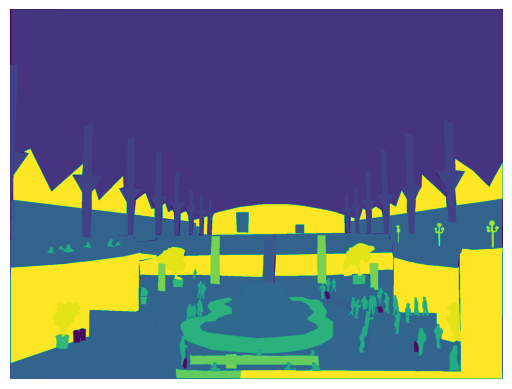

In [10]:
plt.imshow(mask)
plt.axis('off');

In [11]:
val_dataset = ADE20KDataset(DATA_ROOT, mode='val')
len(val_dataset)

2000

In [12]:
image, mask = val_dataset[0]

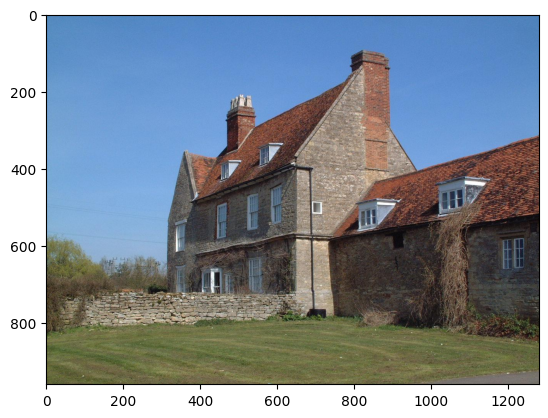

In [ ]:
plt.imshow(image);

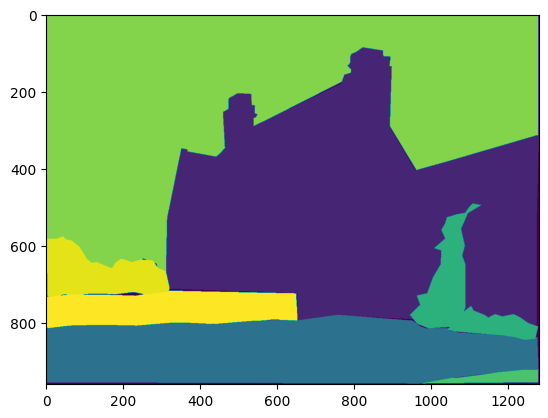

In [15]:
plt.imshow(mask);

In [3]:
train_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='train')
len(train_simple_wall_dataset)

13520

In [4]:
image, mask = train_simple_wall_dataset[0]
type(image), type(mask)

(numpy.ndarray, numpy.ndarray)

In [5]:
image.dtype, image.shape

(dtype('uint8'), (3, 512, 512))

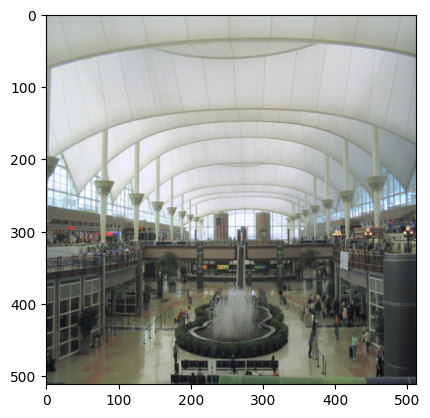

In [6]:
plt.imshow(image.transpose((1, 2, 0)));

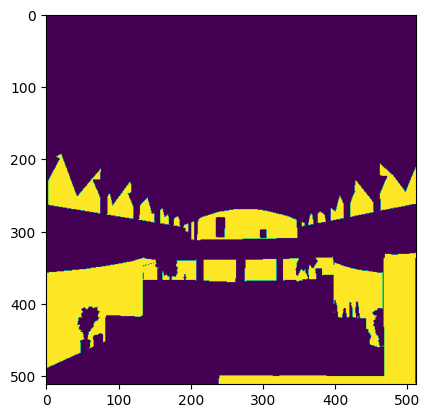

In [8]:
plt.imshow(mask.reshape(512, 512));

In [10]:
val_simple_wall_dataset = SimpleWallADE20KDataset(DATA_ROOT, mode='val')
len(val_simple_wall_dataset)

1181

In [11]:
image, mask = val_simple_wall_dataset[0]
type(image), type(mask)

(numpy.ndarray, numpy.ndarray)

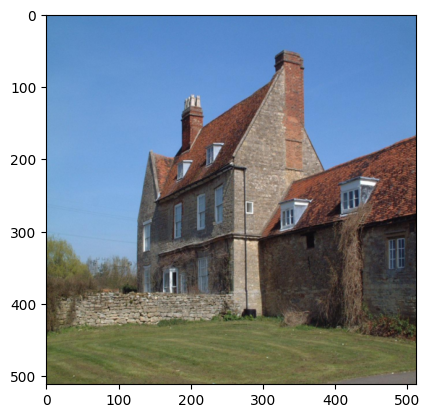

In [12]:
plt.imshow(image.transpose((1, 2, 0)));

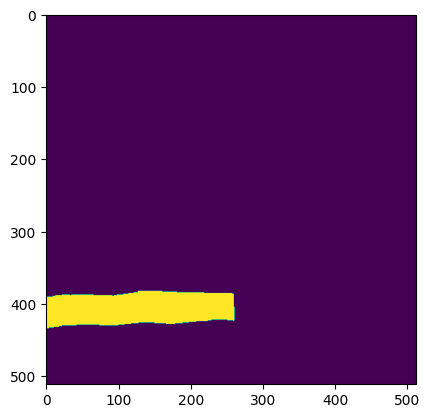

In [13]:
plt.imshow(mask.reshape(512, 512));
# TODO: probably need to filter out outdoor scenes as well

In [14]:
wall_dataset = WallADE20KDataset(DATA_ROOT)

In [15]:
image, mask = wall_dataset[0]

In [16]:
mask.shape, mask.dtype, np.unique(mask)

((1536, 2048), dtype('float32'), array([0., 1.], dtype=float32))

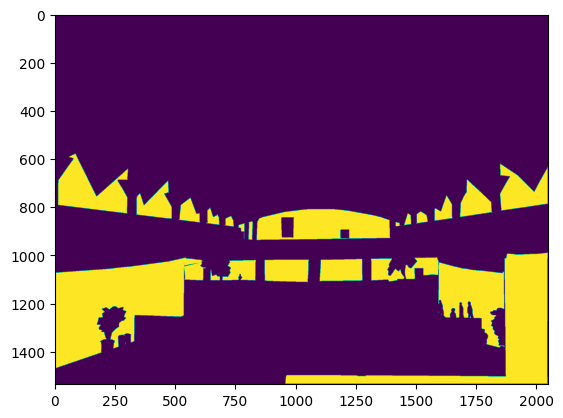

In [17]:
plt.imshow(mask);

In [34]:
train_dataloader = DataLoader(simple_wall_dataset, batch_size=3, shuffle=True, num_workers=1)

In [36]:
sample = next(iter(train_dataloader))

In [37]:
sample[0].dtype, sample[1].dtype

(torch.uint8, torch.float32)

In [38]:
sample[0].shape, sample[1].shape

(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [39]:
sample[0].min(), sample[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [24]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [25]:
# Download data
root = "./dataset"
SimpleOxfordPetDataset.download(root)

In [26]:
train_dataset = SimpleOxfordPetDataset(root, "train")

In [27]:
train_dataloader = DataLoader(simple_wall_dataset, batch_size=3, shuffle=True, num_workers=1)

In [28]:
sample = next(iter(train_dataloader))

In [31]:
sample[0].dtype, sample[1].dtype

(torch.uint8, torch.float32)

In [30]:
sample[0].shape, sample[1].shape

(torch.Size([3, 3, 512, 512]), torch.Size([3, 1, 512, 512]))

In [29]:
sample[0].min(), sample[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [5]:
dataset.index.keys()

dict_keys(['filename', 'folder', 'objectIsPart', 'objectPresence', 'objectcounts', 'objectnames', 'proportionClassIsPart', 'scene', 'wordnet_found', 'wordnet_level1', 'wordnet_synset', 'wordnet_hypernym', 'wordnet_gloss', 'wordnet_frequency', 'description'])

In [7]:
folder = dataset.index['folder'][0]
print(folder)

ADE20K_2021_17_01/images/ADE/training/transportation/airport_terminal


In [12]:
folder.split('/')[3]

'training'

In [91]:
def _is_training_folder(folder: str) -> bool:
    split = folder.split('/')[3]
    return split == 'training'

dataset = ADE20KDataset(DATA_ROOT, mode='train')
index = dataset.index

num_total_images = len(index['filename'])
indices_to_delete = []
for i in range(0, num_total_images):
    if _is_training_folder(index['folder'][i]):
        indices_to_delete.append(i)

# indices_to_delete = set(indices_to_delete)
len(indices_to_delete)

25574

In [36]:
import numpy as np

In [92]:
remaining_indices = [i for i in range(0, len(index['filename'])) if i not in indices_to_delete]
remaining_indices

[25258,
 25259,
 25260,
 25261,
 25262,
 25263,
 25264,
 25265,
 25266,
 25267,
 25268,
 25269,
 25270,
 25271,
 25272,
 25273,
 25274,
 25275,
 25276,
 25277,
 25278,
 25279,
 25280,
 25281,
 25282,
 25283,
 25284,
 25285,
 25286,
 25287,
 25288,
 25289,
 25290,
 25291,
 25292,
 25293,
 25294,
 25295,
 25296,
 25297,
 25298,
 25299,
 25300,
 25301,
 25302,
 25303,
 25304,
 25305,
 25306,
 25307,
 25308,
 25309,
 25310,
 25311,
 25312,
 25313,
 25314,
 25315,
 25316,
 25317,
 25318,
 25319,
 25320,
 25321,
 25322,
 25323,
 25324,
 25325,
 25326,
 25327,
 25328,
 25329,
 25330,
 25331,
 25332,
 25333,
 25334,
 25335,
 25336,
 25337,
 25338,
 25339,
 25340,
 25341,
 25342,
 25343,
 25344,
 25345,
 25346,
 25347,
 25348,
 25349,
 25350,
 25351,
 25352,
 25353,
 25354,
 25355,
 25356,
 25357,
 25358,
 25359,
 25360,
 25361,
 25362,
 25363,
 25364,
 25365,
 25366,
 25367,
 25368,
 25369,
 25370,
 25371,
 25372,
 25373,
 25374,
 25375,
 25376,
 25377,
 25378,
 25379,
 25380,
 25381,
 25382,


In [93]:
remaining_N = len(remaining_indices)
remaining_N

2000

In [94]:
num_classes = len(index['objectPresence'])

updated_object_presence = np.zeros((num_classes, remaining_N), dtype=np.uint8)
updated_object_presence.shape

(3688, 2000)

In [96]:
for c in range(0, num_classes):
    for i in range(0, remaining_N):
        rem_i = remaining_indices[i]
        updated_object_presence[c][i] = index['objectPresence'][c][rem_i]

TypeError: 'set' object is not subscriptable

In [62]:
index['objectPresence'] = updated_object_presence

In [68]:
remaining_indices = set(remaining_indices)
index['filename'] = [x for i, x in enumerate(index['filename']) if i in remaining_indices]
index['folder'] = [x for i, x in enumerate(index['folder']) if i in remaining_indices]

In [69]:
len(index['filename']), len(index['folder']), len(index['objectPresence'][0])

(2000, 2000, 2000)

In [30]:
for c in range(0, len(index['objectPresence'])):
    index['objectPresence'][c] = [x for i, x in enumerate(index['objectPresence'][c, i]) if i not in indices_to_delete]

TypeError: 'numpy.uint8' object is not iterable

In [29]:
index['objectPresence'][0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)